# Understanding RNN's and LSTM's:

In [2]:
!pip install fastai2

In [0]:
from fastai2.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [0]:
from IPython.display import Image, display

## Simple Dataset

In [5]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [6]:
# concatenate train and valid data with a '.' as a separator 
text = ' . '.join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [7]:
# tokenization
tokens = text.split(' ')
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [8]:
# vocab
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [9]:
# numericalization

# reference dictionary for numericalization
word2idx = {w:i for i,w in enumerate(vocab)}

nums = L(word2idx[i] for i in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

## Language model from scratch

In [10]:
# Predicting next word using 3 previous words
L((tokens[i:i+3], tokens[i+3]) for i in range(0,len(tokens)-4,3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

In [11]:
seqs = L((tensor(nums[i:i+3]), nums[i+3]) for i in range(0,len(nums)-4,3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [0]:
# Creating a dataloader
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

## Language Model in PyTorch

The first linear layer will use only the first word's embedding as activations, the second layer will use the second word's embedding plus the first layer's output activations, and the third layer will use the third word's embedding plus the second layer's output activations. The key effect of this is that every word is interpreted in the information context of any words preceding it.

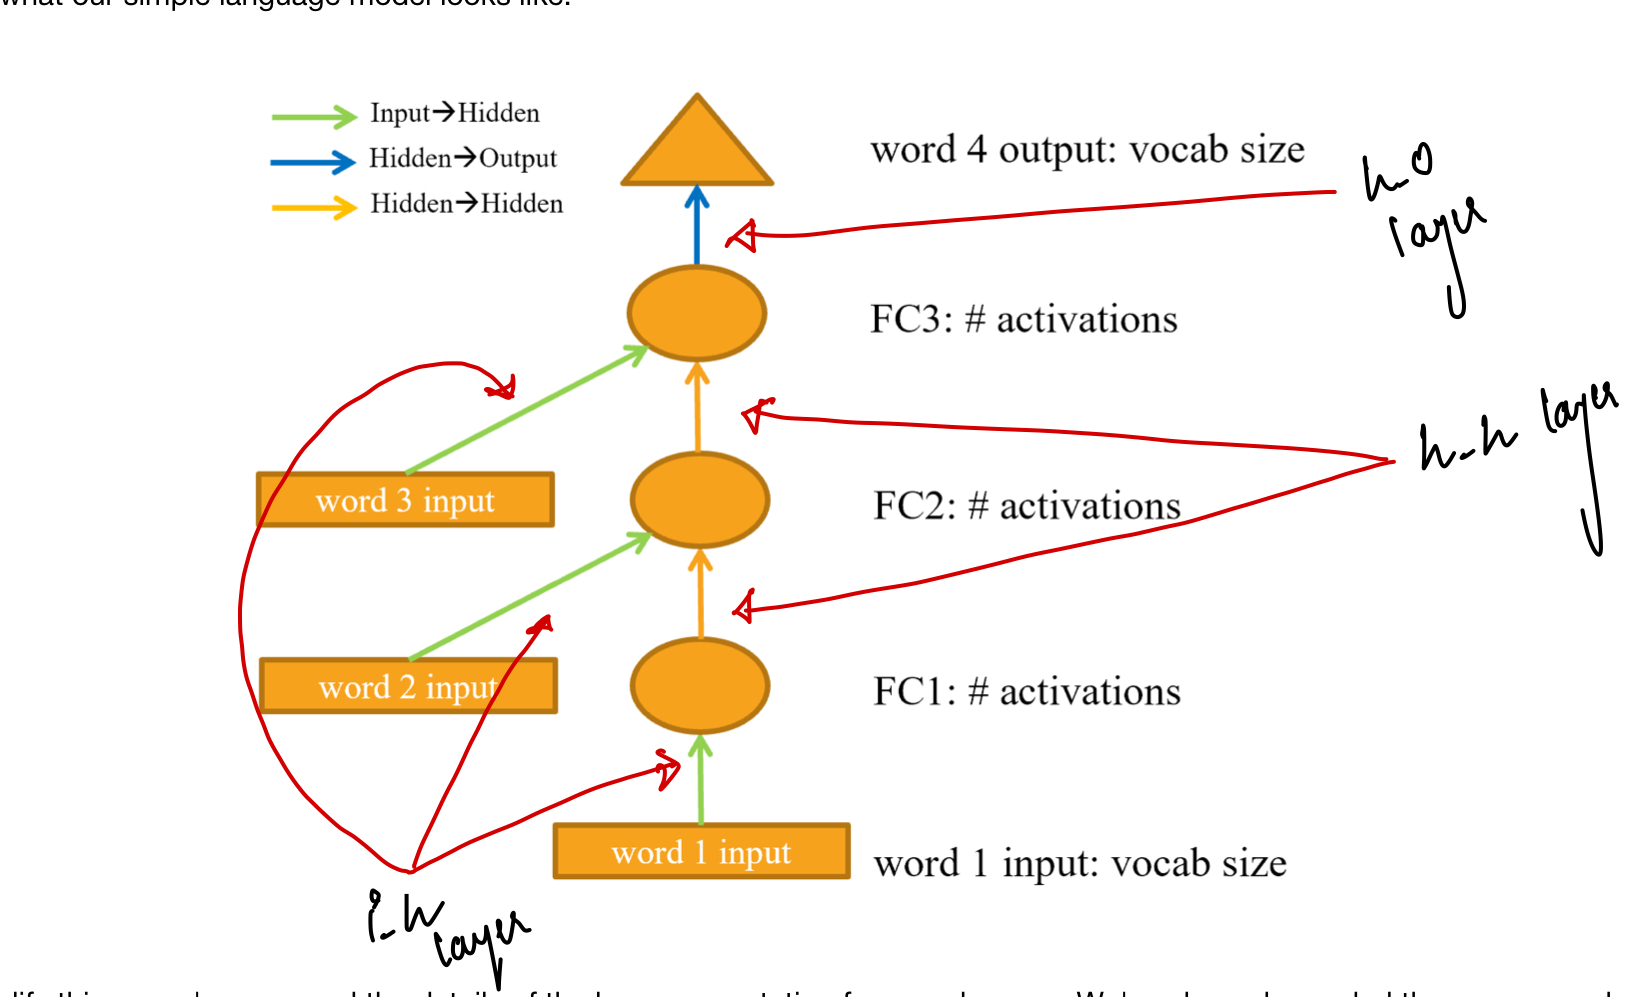

In [13]:
display(Image('/content/drive/My Drive/my_fastai_notebooks/Text/data/images/LMModel1.jpeg', retina=True))

In [0]:
class LMModel1(Module):
  def __init__(self, vocab_sz, n_hidden):
    self.i_h = nn.Embedding(vocab_sz, n_hidden) #embedding layer to embed input words
    self.h_h = nn.Linear(n_hidden, n_hidden) #linear layer to create activations for thenext word(hidden to hidden layer)
    self.h_o = nn.Linear(n_hidden, vocab_sz) #final layer to predict 4th word(hidden to output)
  
  def forward(self, x):
    h = F.relu(self.h_h(self.i_h(x[:, 0])))
    h = h + self.i_h(x[:, 1])
    h = F.relu(self.h_h(h))
    h = h + self.i_h(x[:, 2])
    h = F.relu(self.h_h(h))
    return self.h_o(h)


In [15]:
model = LMModel1(len(vocab), 64) #initialize LMModel1 with vocab size and number of hidden layers

learn = Learner(dls, model,loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.883641,1.885023,0.461136,00:03
1,1.400446,1.702164,0.479914,00:03
2,1.397828,1.635806,0.501070,00:03
3,1.355949,1.584144,0.500357,00:03


### How to compare a model to a baseline?

Baseline here would would be a model that predicts the most common token in the dataset everytime. let's find that token and see what the accuracy is:

In [16]:
n,counts = 0,torch.zeros(len(vocab))

for x,y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab): counts[i] += (y==i).long().sum()

idx = torch.argmax(counts)
idx, vocab[idx.item()], counts[idx].item()/n

(tensor(29), 'thousand', 0.15165200855716662)

The most common word is 'thousand' and a model that only predicts that would have an accuracy of 15%. Our initial model fares much better than that.  

## Recurrent Neural Networks

Refactoring above code to removing duplication

In [0]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
    def forward(self, x):
      h = 0
      for i in range(3):
          h = h + self.i_h(x[:,i])
          h = F.relu(self.h_h(h))
      return self.h_o(h)

In [18]:
learn = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.815902,1.975118,0.464939,00:03
1,1.376741,1.718403,0.475636,00:03
2,1.403230,1.624596,0.492988,00:03
3,1.370249,1.744054,0.360827,00:03


A neural network which is defined using a loop like this is called a recurrent neural network, also known as an RNN.

### Improving RNN

In [0]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0 #By initializing hidden layer output here, we don't need to reset data learnt every epoch
        
    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach() # This is to ensure that gradient accumulation isn't too much
        return out
    
    def reset(self): self.h = 0 # Then and again reset to avoid over collection

In [0]:
# Ensuring LMModel3 sees the sequence of inputs in flowing manner
m = len(seqs)//bs
m,bs,len(seqs)

def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)
# Note: drop_last=True when building our DataLoaders to drop the last batch that has not a shape of bs, 
# also pass shuffle=False to make sure the texts are read in order.

In [21]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelReseter)
# Note: Here 'ModelRester' callback is used to call the reset method of the LMModel3 class then and again to avoid overaccumulation of stream of data

learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.706558,1.833424,0.466827,00:03
1,1.262296,1.650505,0.506010,00:03
2,1.096928,1.620142,0.526923,00:03
3,1.030721,1.592250,0.562981,00:03
4,0.986334,1.602184,0.568269,00:03
5,0.928258,1.535064,0.589183,00:03
6,0.868371,1.577676,0.595673,00:03
7,0.820496,1.527196,0.602163,00:03
8,0.796789,1.546749,0.619952,00:03
9,0.780831,1.546998,0.620433,00:03


### Creating more signal:

A problem with our current approach is that we only predict one output word for each three input words. That means that the amount of signal that we are feeding back to update weights with is not as large as it could be. It would be better if we predicted the next word after every single word, rather than every three words

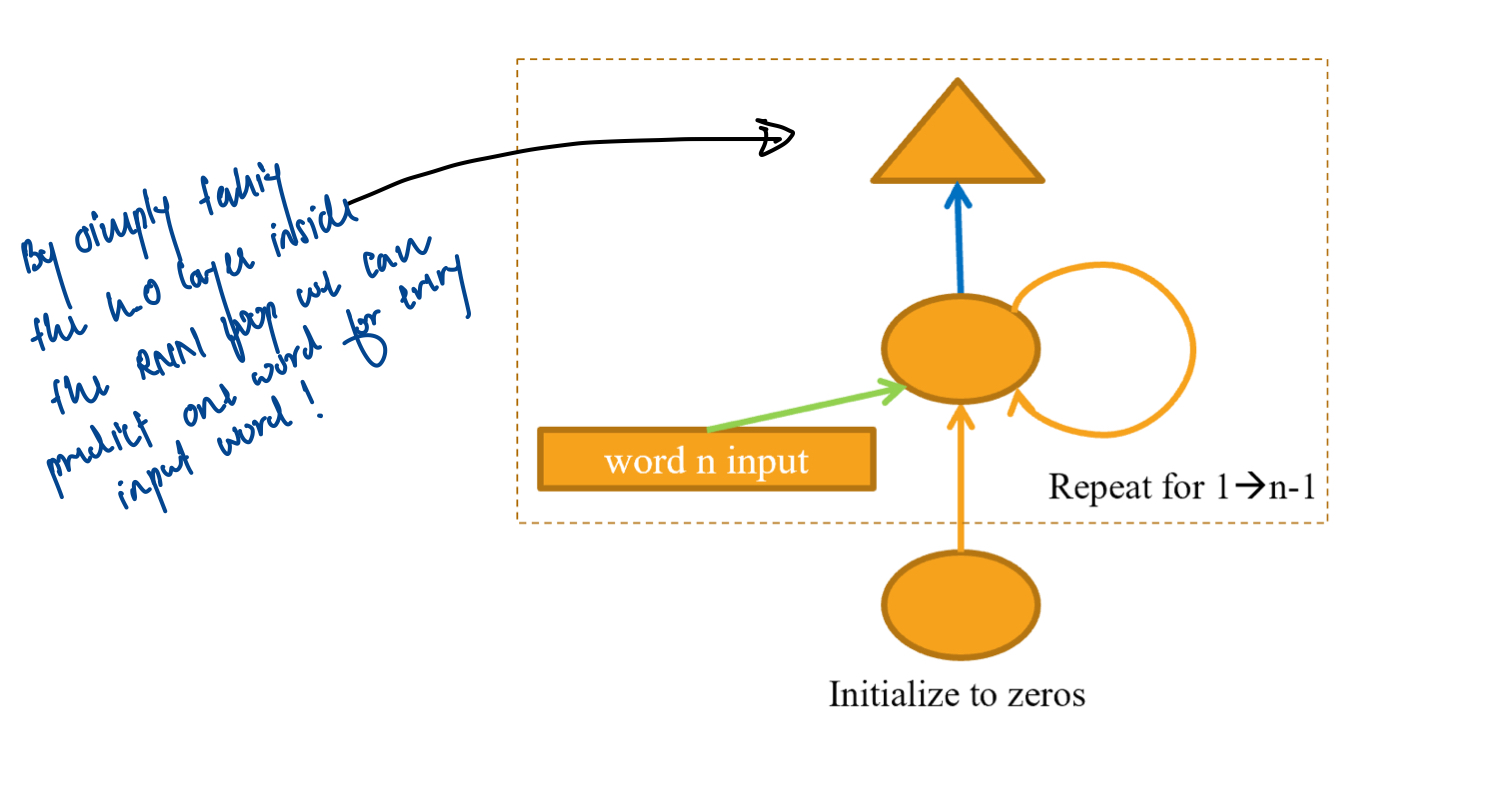

In [22]:
 display(Image('/content/drive/My Drive/my_fastai_notebooks/Text/data/images/rnn_more_signal.jpeg', retina=True))

In [0]:
# Changing dataloader to predict one ford for one input word
sl = 16
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [24]:
# Looking at the first element of seqs, we can see that it contains two lists of the same size. 
# The second list is the same as the first, but offset by one element:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

In [0]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0

    def forward(self, x):
      outs = [] #something to store output at every word input
      for i in range(sl):
          self.h = self.h + self.i_h(x[:,i])
          self.h = F.relu(self.h_h(self.h))
          outs.append(self.h_o(self.h)) # append output at every sequence
      self.h = self.h.detach() # to avoid accumulation
      return torch.stack(outs, dim=1) #output a sequence of predictions at every input
  
    def reset(self): self.h = 0
      

This model will return outputs of shape bs x sl x vocab_sz (since we stacked on dim=1). Our targets are of shape bs x sl, so we need to flatten those before using them in F.cross_entropy:

In [0]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [27]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelReseter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.214794,2.986535,0.281494,00:00
1,2.317741,1.951337,0.465902,00:01
2,1.746506,1.842908,0.450684,00:00
3,1.436180,1.902875,0.526530,00:00
4,1.246440,2.043517,0.552246,00:00
5,1.070677,2.288072,0.512044,00:01
6,0.934915,2.294943,0.554850,00:00
7,0.818524,2.422090,0.561768,00:00
8,0.730093,2.528309,0.572184,00:00
9,0.684656,2.417703,0.569743,00:00


## Multilayer RNN's

Let's save some time by using PyTorch's RNN class, which implements exactly what we have created above, but also gives us the option to stack multiple RNNs, as we have discussed:

In [0]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [29]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelReseter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.046464,2.539997,0.456543,00:01
1,2.145966,1.779129,0.472493,00:01
2,1.694118,1.846425,0.346354,00:01
3,1.465004,1.723906,0.505046,00:01
4,1.301629,1.930464,0.524902,00:01
5,1.150041,1.938477,0.557699,00:00
6,1.014439,2.058145,0.594157,00:00
7,0.889027,2.059259,0.619954,00:01
8,0.782196,2.128993,0.634277,00:01
9,0.704950,2.251250,0.629557,00:01


That has produced worse results than before. This is because stacked RNN's make the model deep and thus leads to the most common problem and flaw of RNN's which is exploding and dissappearing activations! 



## Exploding and dissapearing gradients:

In practice, creating accurate models from this kind of RNN is difficult. We will get better results if we call detach less often, and have more layers — this gives our RNN a longer time horizon to learn from, and richer features to create. But it also means we have a deeper model to train. The key challenge in the development of deep learning has been figuring out how to train these kinds of models.
The reason this is challenging is because of what happens when you multiply by a matrix many times. Think about what happens when you multiply by a number many times. For example, if you multiply by two, starting at one, you get the sequence 1, 2, 4, 8,… after 32 steps you are already at 4,294,967,296. A similar issue happens if we multiply by 0.5: we get 0.5, 0.25, 0.125… and after 32 steps it's 0.00000000023. As you can see, a number even slightly higher or lower than one results in an explosion or disappearance of our number, after just a few repeated multiplications.
Because matrix multiplication is just multiplying numbers and adding them up, exactly the same thing happens with repeated matrix multiplications. And a deep neural network is just repeated matrix multiplications--each extra layer is another matrix multiplication. This means that it is very easy for a deep neural network to end up with extremely large, or extremely small numbers.

This inaccuracy means that often the gradients calculated for updating the weights end up as zero or infinity for deep networks. This is commonly refered to as vanishing gradients or exploding gradients. That means that in SGD, the weights are updated either not at all, or jump to infinity. Either way, they won't improve with training.

Solution: LSTM's and GRU's

## GRU's

In [0]:
class LMModel_GRU(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.GRU(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): 
        self.h.zero_()

In [47]:
learn = Learner(dls, LMModel_GRU(len(vocab), 64, 1), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelReseter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.825510,2.520106,0.285156,00:01
1,1.908614,1.962634,0.321126,00:01
2,1.512518,1.711146,0.471761,00:01
3,1.167527,1.849105,0.544678,00:01
4,0.880382,1.793948,0.587646,00:01
5,0.653750,1.582051,0.639648,00:01
6,0.484271,1.424835,0.710286,00:01
7,0.333621,1.374827,0.749593,00:01
8,0.212692,1.210235,0.781087,00:01
9,0.134298,1.233629,0.795085,00:01


## LSTM's

LSTM (for long short-term memory) is an architecture that was introduced back in 1997 by Jurgen Schmidhuber and Sepp Hochreiter. In this architecture, there are not one but two hidden states. In our base RNN, the hidden state is the output of the RNN at the previous time step. That hidden state is then responsible for doing two things at a time:
having the right information for the output layer to predict the correct next token
retaining memory of everything that happened in the sentence
Consider, for example, the sentences "Henry has a dog and he likes his dog very much" and "Sophie has a dog and she likes her dog very much". It's very clear that the RNN needs to remember the name at the beginning of the sentence to be able to predict he/she or his/her.
In practice, RNNs are really bad at retaining memory of what happened much earlier in the sentence, which is the motivation to have another hidden state (called cell state) in the LSTM. The cell state will be responsible for keeping long short-term memory, while the hidden state will focus on the next token to predict. Let's have a closer look and how this is achieved and build one LSTM from scratch.

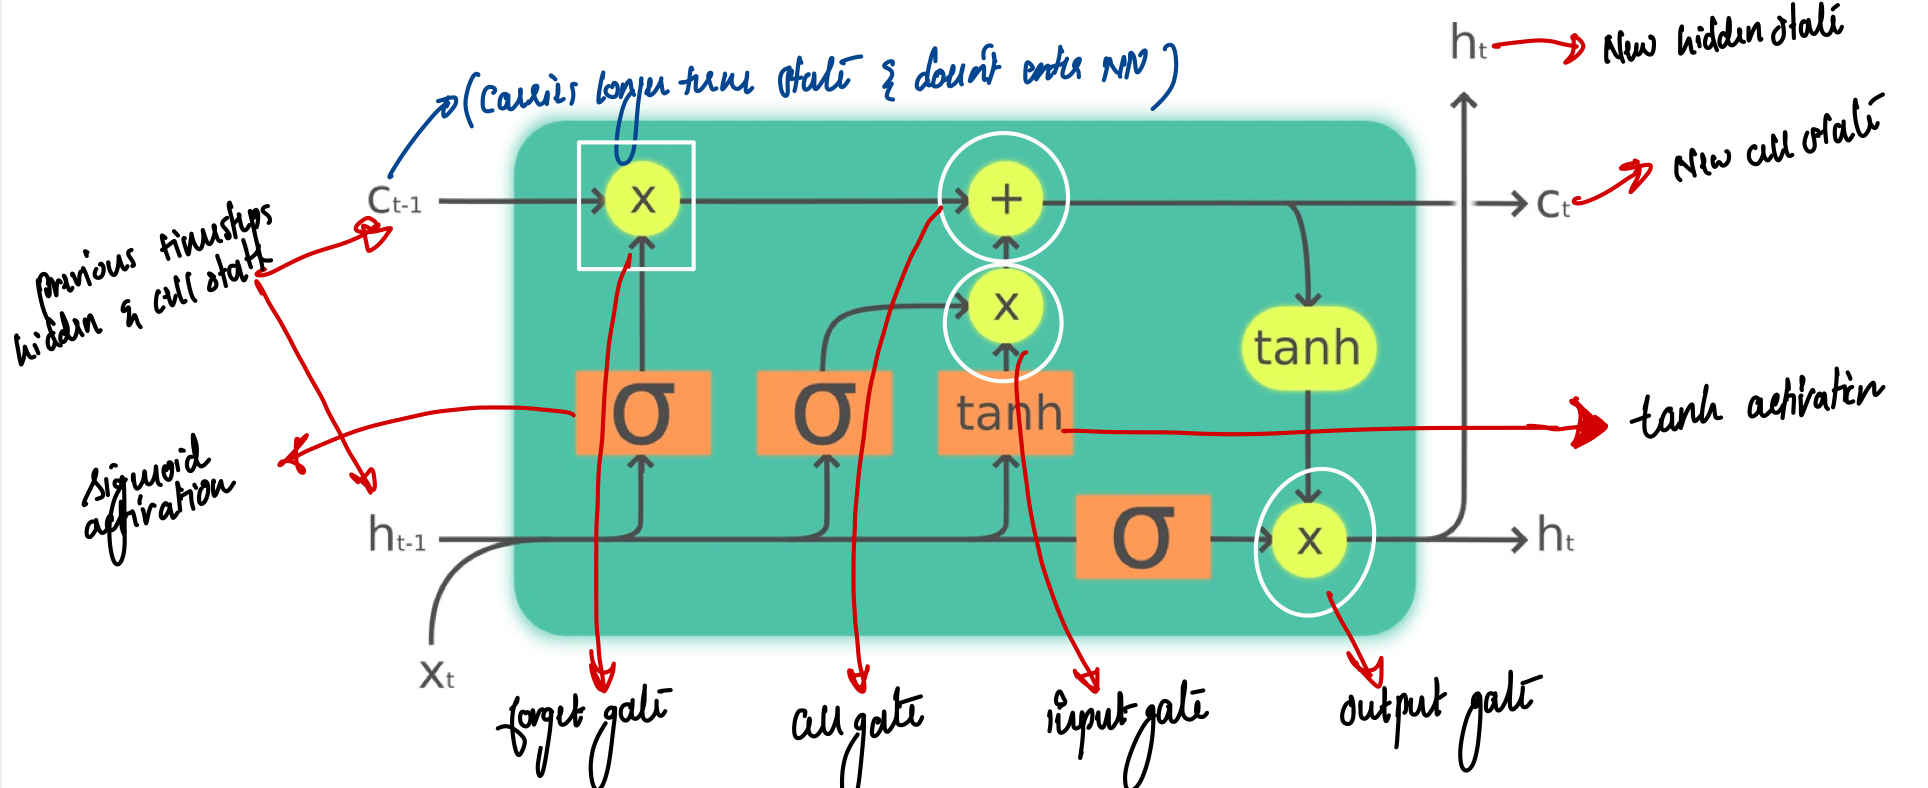

In [0]:
 display(Image('/content/drive/My Drive/my_fastai_notebooks/Text/data/images/lstm.jpeg', retina=True))

In this picture, our input $x_{t}$ enters on the bottom with the previous hidden state ($h_{t-1}$) and cell state ($c_{t-1}$). The four orange boxes represent four layers with the activation being either sigmoid (for $\sigma$) or tanh. tanh is just a sigmoid rescaled to the range -1 to 1. Its mathematical expression can be written like this:

$$\tanh(x) = \frac{e^{x} + e^{-x}}{e^{x}-e^{-x}} = 2 \sigma(2x) - 1$$

where $\sigma$ is the sigmoid function. The green boxes are elementwise operations. What goes out is the new hidden state ($h_{t}$) and new cell state ($c_{t}$) on the right, ready for our next input. The new hidden state is also used as output, which is why the arrow splits to go up.

Let's go over the four neural nets (called *gates*) one by one and explain the diagram, but before this, notice how very little the cell state (on the top) is changed. It doesn't even go directly through a neural net! This is exactly why it will carry on a longer-term state.

First, the arrows for input and old hidden state are joined together. In the RNN we wrote before in this chapter, we were adding them together. In the LSTM, we stack them in one big tensor. This means the dimension of our embeddings (which is the dimension of $x_{t}$) can be different than the dimension of our hidden state. If we call those `n_in` and `n_hid`, the arrow at the bottom is of size `n_in + n_hid`, thus all the neural nets (orange boxes) are linear layers with `n_in + n_hid` inputs and `n_hid` outputs.

The first gate (looking from the left to right) is called the *forget gate*. Since it's a linear layer followed by a sigmoid, its output will have scalars between 0 and 1. We multiply this result by the cell gate, so for all the values close to 0, we will forget what was inside that cell state (and for the values close to 1 it doesn't do anything). This gives the ability to the LSTM to forget things about its longterm state. For instance, when crossing a period or an `xxbos` token, we would expect to it to (have learned to) reset its cell state.

The second gate is called the *input gate*. It works with the third gate (which doesn't really have a name but is sometimes called the *cell gate*) to update the cell state. For instance we may see a new gender pronoun, so we must replace the information about gender that the forget gate removed by the new one. Like the forget gate, the input gate ends up on a product, so it just decides which element of the cell state to update (values close to 1) or not (values close to 0). The third gate will then fill those values with things between -1 and 1 (thanks to the tanh). The result is then added to the cell state.

The last gate is the *output gate*. It will decides which information take in the cell state to generate the output. The cell state goes through a tanh before this and the output gate combined with the sigmoid decides which values to take inside it.


In terms of code, we can write the same steps like this:

In [0]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate  = nn.Linear(ni + nh, nh)
        self.cell_gate   = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)

    def forward(self, input, state):
        h,c = state
        h = torch.stack([h, input], dim=1)
        forget = torch.sigmoid(self.forget_gate(h))
        c = c * forget
        inp = torch.sigmoid(self.input_gate(h))
        cell = torch.tanh(self.cell_gate(h))
        c = c + inp * cell
        out = torch.sigmoid(self.output_gate(h))
        h = outgate * torch.tanh(c)
        return h, (h,c)

A little refactoring leads to this:

In [0]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.ih = nn.Linear(ni,4*nh)
        self.hh = nn.Linear(nh,4*nh)

    def forward(self, input, state):
        h,c = state
        #One big multiplication for all the gates is better than 4 smaller ones
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        ingate,forgetgate,outgate = map(torch.sigmoid, gates[:3])
        cellgate = gates[3].tanh()

        c = (forgetgate*c) + (ingate*cellgate)
        h = outgate * c.tanh()
        return h, (h,c)

In [0]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.lstm = LSTMCell(n_layers, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        h, res = self.lstm(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self):
      self.h.zero_()

In [84]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelReseter)

# learn.fit_one_cycle(15, 1e-2)
learn.summary()

RuntimeError: ignored

Training a model using the LSTM cell in PyTorch

In [0]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [60]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelReseter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.980281,2.584468,0.437663,00:01
1,2.049535,2.180541,0.317790,00:01
2,1.556980,1.768154,0.482747,00:01
3,1.272767,2.042736,0.509033,00:01
4,0.973432,1.847653,0.580811,00:01
5,0.664757,1.733798,0.651693,00:01
6,0.432424,1.544520,0.701172,00:01
7,0.274550,1.456356,0.744303,00:01
8,0.166484,1.424272,0.771322,00:01
9,0.097201,1.243558,0.775228,00:01


## Regularizing LSTM

AR (for activation regularization) and TAR (for temporal activation regularization) are two regularization methods very similar to weight decay. When applying weight decay, we add a small penalty to the loss that aims at making the weights as small as possible. For the activation regularization, it's the final activations produced by the LSTM that we will try to make as small as possible, instead of the weights.

To regularize the final activations, we have to store those somewhere, then add the means of the squares of them to the loss (along with a multiplier `alpha`, which is just like `wd` for weight decay):

``` python
loss += alpha * activations.pow(2).mean()
```

Temporal activation regularization is linked to the fact we are predicting tokens in a sentence. That means it's likely that the outputs of our LSTMs should somewhat make sense when we read them in order. TAR is there to encourage that behavior by adding a penalty to the loss to make the difference between two consecutive activations as small as possible

Our activations tensor has a shape `bs x sl x n_hid`, and we read consecutive activation on the sequence length axis (so the dimension in the middle). With this, TAR can be expressed as:

``` python
loss += beta * (activations[:,1:] - activations[:,:-1]).pow(2).mean()
```

`alpha` and `beta` are then two hyper-parameters to tune. To make this work, we need our model with dropout to return three things: the proper output, the activations of the LSTM pre-dropout and the activations of the LSTM post-dropout. AR is often applied on the dropped out activations (to not penalize the activations we turned in 0s afterward) while TAR is applied on the non-dropped out activations (because those 0s create big differences between two consecutive timesteps). There is then a callback called `RNNRegularizer` that will apply this regularization for us.

In [0]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p) # Adding droput
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight # Weight tying
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

In [0]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelReseter, RNNRegularizer(alpha=2, beta=1)]) #Adding AR and TAR regularization

In [0]:
learn.fit_one_cycle(15, 1e-2, wd=0.1)

In [0]:
# Fastai's TextLearner automatically adds AR and TAR
learn = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
                    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(15, 1e-2, wd=0.1)